# 2CS-SIL2/SIQ2 Lab02. Regularization and Feature selection

<p style='text-align: right;font-style: italic;'>Designed by: Abdelkrime Aries</p>

In this lab, we will learn about:
- Regularization
- Feature selection

**Team:**
- **Member 01**: Ouadi Amina Tinhinene
- **Member 02**: Amoura Yousra
- **Group**: *2*

In [ ]:
import sys, timeit
import datetime
from typing          import Tuple, List, Type
from collections.abc import Callable

sys.version

'3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]'

In [ ]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.26.4', '2.2.2', '3.10.0')

In [ ]:
import sklearn

from sklearn.metrics           import f1_score
from sklearn.linear_model      import LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector


sklearn.__version__

'1.6.1'

In [ ]:
# This code is used to filter warnings concerning convergence
# In general, when the maximum number of iterations is not suffisant to converge
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [ ]:
# Logistic regression code
# Do not modify this code, or earth will eat itself

# Weighted sum
def zf(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return X @ theta

# Sigmoid function
def sg(Z: np.ndarray) -> np.ndarray:
    return  1 / (1 + np.exp(-Z))

# Probability estimation
def hf(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return sg(zf(X, theta))

# Loss function
def BCE(Y: np.ndarray, H: np.ndarray, e: float=1e-8) -> float:
    return - np.mean(Y * np.log(H + e) + (1-Y) * np.log(1-H + e))

# Gradients
def dBCE(X: np.ndarray, Y: np.ndarray, H: np.ndarray) -> np.ndarray:
    return  np.dot(X.T, H-Y)/X.shape[0]

# Parameters update
def update(Theta: np.ndarray, Gradient: np.ndarray, alpha: np.ndarray) -> np.ndarray:
    return Theta - alpha * Gradient

# Normalization
def normalize(X: np.ndarray, mean: np.ndarray=None, std: np.ndarray=None) -> np.ndarray:
    if (mean is None) or (std is None):
        mean = np.mean(X, axis=0)
        std  = np.std(X, axis=0)
    X_norm = np.where(std==0, X, (X - mean)/std)
    return X_norm, mean, std


def prepare(X: np.ndarray, norm: np.ndarray=True,
             const: np.ndarray=True, mean: np.ndarray=None, std: np.ndarray=None) -> np.ndarray:
    X_pre = X.copy()
    if norm:
        X_pre, mean, std = normalize(X_pre,mean=mean, std=std)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std

def generate_zeros_1(nbr: int) -> np.ndarray:
    return np.zeros(nbr)

def generate_ones_1(nbr: int) -> np.ndarray:
    return np.ones(nbr)

print('DONE')

DONE


## I. Algorithms implementation

In this section, we will try to implement some regularization functions as well as a filtering one.
Regularization will be applied on logistic regression.

### I.1.  L2 penalty

L2 penalty + Linear regression = Ridge regression.

#### I.2.1. L2 cost function

**L2** cost function is calculated as:

$$J_{L2}(\theta) = \frac{\lambda }{2M} \sum\limits_{j=1}^{N} \theta_j^2$$

- **M**: number of samples
- **N**: number of features


**Note** In some references, this regularization is not divided by $M$. In practice, it must be normalized over $M$. [This is an answer on stackexchange](https://stats.stackexchange.com/questions/287920/regularisation-why-multiply-by-1-2m) explaining why. A side information: for one sample, we call it 'loss function', for a batch it is called 'cost function'.

In [ ]:
# TODO: L2 cost function
def J_L2(Theta: np.ndarray, M: int, Lambda: float=0.) -> float:
     return (Lambda / (2 * M)) * np.sum(Theta[1:] ** 2)

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (0.0, 0.0005050000000000001)
#---------------------------------------------------------------------

# The first element is the bias,
# thus it must not be included in the cost
Theta_t = np.array([1, 0.01, 0.1])


J_L2(Theta_t, 4), J_L2(Theta_t, 4, Lambda=.4)

(0.0, 0.0005050000000000001)

#### 1.2.2. L2 gradient function

**L2** gradient function is given as:

$$\frac{\partial J_{L2}(\theta)}{\partial \theta_j} = \frac{\lambda }{M} \theta_j \text{ if } j > 0$$

$$\frac{\partial J_{L2}(\theta)}{\partial \theta_0} = 0$$

- **M**: number of samples
- **N**: number of features


In [ ]:
# TODO: L2 gradient function
def dJ_L2(Theta: np.ndarray, M: int, Lambda: float=0.) -> np.ndarray:
    grad = np.zeros_like(Theta)  # Initialize gradient array with zeros
    grad[1:] = (Lambda / M) * Theta[1:]  # Apply gradient formula for j > 0
    return grad


#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))
#---------------------------------------------------------------------

# The first element is the bias,
# thus it must always have a gradient of 0
Theta_t = np.array([1, 0.01, 0.1])

dJ_L2(Theta_t, 4), dJ_L2(Theta_t, 4, Lambda=0.4)

(array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))

### I.2.  L1 penalty

L1 penalty + Linear regression = Lasso regression.

#### I.2.1. L2 cost function

**L1** cost function is calculated as:

$$J_{L1}(\theta) = \frac{\lambda}{M} \sum\limits_{j=1}^{N} |\theta_j|$$

- **M**: number of samples
- **N**: number of features

In [ ]:
# TODO: L1 cost function
def J_L1(Theta: np.ndarray, M: int, Lambda: float=0.) -> float:
    return (Lambda / M) * np.sum(np.abs(Theta[1:]))

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (0.0, 0.011000000000000001)
#---------------------------------------------------------------------

# The first element is the bias,
# thus it must not be included in the cost
Theta_t = np.array([1, 0.01, 0.1])

J_L1(Theta_t, 4), J_L1(Theta_t, 4, Lambda=.4)

(0.0, 0.011000000000000001)

#### I.2.2. Soft-Thresholding

$L1$ derivative is:
$$\frac{\partial L1}{\partial \theta_j} = \frac{\partial \frac{\lambda }{M} \sum\limits_{j=1}^{N} |\theta_j|}{\partial \theta_j} = \frac{\lambda }{M} \frac{\theta_j}{|\theta_j|}$$

It is clear that the gradient is not defined when $\theta_j = 0$.
Applying [Subderivative](https://en.wikipedia.org/wiki/Subderivative), we'll get:
$$
\frac{\partial L1}{\partial \theta_j} =
\begin{cases}
-\frac{\lambda}{M} & \text{if } \theta_j < 0 \\
0 & \text{si } \theta_j = 0 \\
\frac{\lambda}{M} & \text{if } \theta_j > 0 \\
\end{cases}
$$

Nous ne pouvons pas utiliser la descente du gradient pour résoudre ça.
Nous allons utiliser un algorithme de descente du gradient approximative, qui s'appelle **Iterative soft-thresholding algorithm (ISTA)**.
$$prox(\theta) = S_{\lambda}(\theta) =
\begin{cases}
\theta_j + \lambda & \text{si } \theta_j < - \lambda \\
0 & \text{si } -\lambda \le \theta_j \le \lambda \\
\theta_j - \lambda & \text{si } \theta_j > \lambda \\
\end{cases}
$$

**Vous devez implémenter cette fonction**

Les thétas sont mises à jour comme suite :
$$ \theta = S_{\lambda}(\theta - \frac{\partial J_0}{\partial \theta})$$
Où, $J_0$ est la fonction du coût sans régularisation

Source : [Ryan Tibshirani (2015), Lecture 08: Proximal Gradient Descent](https://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/08-prox-grad-scribed.pdf)

In [ ]:
# TODO: Soft-thresholding = prox(theta)
def S(Theta: np.ndarray, Lambda: float) -> np.ndarray:
    Theta_new = np.copy(Theta)  # Copy to avoid modifying the input array
    Theta_new[1:] = np.sign(Theta[1:]) * np.maximum(np.abs(Theta[1:]) - Lambda, 0)
    return Theta_new

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# array([ 0.5 , -0.15,  0.  ])
#---------------------------------------------------------------------

# The first element is the bias,
# thus it must not be changed by soft-thresholding
Theta_t = np.array([0.5, -0.25, 0.05])

S(Theta_t, 0.1)

array([ 0.5 , -0.15,  0.  ])

### I.3. Regularized logistic regression

**>> Nothing to code here**

In [ ]:
# これをいじると舌が青くなるよ
# This can be gradient descent or ISTA based on the approx function
def optimize(X: np.ndarray, Y: np.ndarray, Theta: np.ndarray, approx: Callable=None, it_max: int=100, alpha: float=0.1, Lambda: float=0.):

    M = len(Y)

    if approx :
        def maj(Theta, J, dJ):
            J    += J_L1(Theta, M, Lambda=Lambda)
            Theta = update(Theta, dJ, alpha)
            Theta = S(Theta, Lambda/M) # Lamdba is normalized by th number of samples before applying S
            return J, Theta
    else:
        def maj(Theta, J, dJ):
            J    += J_L2(Theta, M, Lambda=Lambda)
            dJ   += dJ_L2(Theta, M, Lambda=Lambda)
            Theta = update(Theta, dJ, alpha)
            return J, Theta

    cost_history  = []
    Theta_history = []

    # we use a copy so that the input stays intact
    Theta  = Theta.copy()

    # here, we iterate till the last breath
    for it in range(it_max):
        H        = hf(X, Theta)
        J        = BCE(Y, H)
        dJ       = dBCE(X, Y, H)
        J, Theta = maj(Theta, J, dJ)
        cost_history.append(J)
        Theta_history.append(Theta.copy())

    return Theta_history, cost_history

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([ 0.94839532, -0.56840255,  1.2813832 ]),
#  array([ 0.46328109, -0.15750488,  0.        ]),
#  array([ 0.93431089, -0.53451115,  1.03711393]))
#
#---------------------------------------------------------------------

X_t = np.array([
    [1, 1, 0.2],
    [1, 2, 0.1],
    [1, 3, 0.4],
    [1, 4, 0.3]
])

Theta_t = np.array([1., 1., 1.])
Y_t     = np.array([1, 0, 1, 0])

# No regularization: Lambda = 0
Theta_P, J_P = optimize(X_t, Y_t, Theta_t)
# L1 optimization: approximation with lambda
Theta_1, J_1 = optimize(X_t, Y_t, Theta_t, approx=S, Lambda=0.1)
# L2 optimization: lambda without approximation
Theta_2, J_2 = optimize(X_t, Y_t, Theta_t, Lambda=0.1)

Theta_P[-1], Theta_1[-1], Theta_2[-1]

(array([ 0.94839532, -0.56840255,  1.2813832 ]),
 array([ 0.46328109, -0.15750488,  0.        ]),
 array([ 0.93431089, -0.53451115,  1.03711393]))

In [ ]:
# Do not modify this
# if you do, you'll get a Vin Diesel head
class RegLogReg(object): # Regularized Logistic Regression

    # By default: no regularization :'(
    def __init__(self, it_max: int=100,
                 alpha: float=.01, Lambda: float=1.0, norm: bool=True, const: bool=True, reg: str=None):
        self.it_max = it_max
        self.alpha    = alpha
        self.norm     = norm
        self.const    = const
        self.approx   = None
        self.Lambda   = Lambda
        if reg == 'l1':
            self.approx = S
        elif reg != 'l2':
            self.Lambda = 0.

    def fit(self, X: np.ndarray, Y: np.ndarray):
        # we have to store mean and std to normalize when predicting
        X_pre, self.mean, self.std = prepare(X, norm=self.norm, const=self.const)
        Theta = generate_ones_1(X_pre.shape[1])
        self.Thetas, self.couts = optimize(X_pre, Y, Theta,
                                          approx=self.approx,
                                          it_max=self.it_max,
                                          alpha =self.alpha,
                                          Lambda=self.Lambda)

    # Prediction
    # if cls=True, the result is a vector of  1 and 0
    # otherwise, it will be a veector of probabilities
    def predict(self, X: np.ndarray, cls: bool=True, thrshold: float=0.5, it: int=-1) -> np.ndarray:
        X_pre, self.mean, self.std = prepare(X, norm=self.norm, const=self.const, mean=self.mean, std=self.std)
        H = hf(X_pre, self.Thetas[it])
        if cls:
            return (H >= thrshold).astype(int)
        return H

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([0.86383643, 0.5273866 , 0.96123235]),
#  array([0.79153709, 0.        , 0.        ]),
#  array([0.8515839 , 0.38351525, 0.7672672 ]),
#  array([0, 0, 1, 1]))
#---------------------------------------------------------------------

X_t = np.array([
    [100, 20],
    [200, 10],
    [300, 40],
    [400, 30]
])

Y_t = np.array([1, 0, 1, 0])

# No regularization
reglog = RegLogReg()
reglog.fit(X_t, Y_t)
# L1 regularization
reglog1 = RegLogReg(reg='l1')
reglog1.fit(X_t, Y_t)
# L2 regularization
reglog2 = RegLogReg(reg='l2')
reglog2.fit(X_t, Y_t)

reglog.Thetas[-1], reglog1.Thetas[-1], reglog2.Thetas[-1], reglog.predict(X_t)

(array([0.86383643, 0.5273866 , 0.96123235]),
 array([ 0.79241836, -0.        ,  0.        ]),
 array([0.8515839 , 0.38351525, 0.7672672 ]),
 array([0, 0, 1, 1]))

### I.4. Filtering (ANOVA: Analysis of Variance)

For each class, there is a different number of samples.
This is why we will implemeent ANOVA for a CRD (COMPLETELY RANDOM DESIGN).
The algorithm is explained in [Richard Horsly (2012) COMPLETELY RANDOM DESIGN (CRD)](https://www.ndsu.edu/faculty/horsley/CRD.pdf).
To validate, we will use the example in page 10.

#### I.4.1. One way F value for one feature

Given a feature ($A$), its values are divided into $N$ sets, where $N$ is the number of classes.

$$CF = \frac{(\sum_{ij} A_{ij})^2}{\sum_j |A_j|} $$
Where $\sum_{ij} A_{ij}$ is the sum of all values of all classes,
$\sum_j |A_j|$ is the number of samples

$$ TotalSS = \sum_{ij} A_{ij}^2 - CF$$
Where $\sum_{ij} A_{ij}^2$ is the sum est les somme of values' squares

$$ TreatmentSS = \sum_j \frac{(\sum_{i} A_{ij})^2}{|A_j|} - CF$$
Where $\sum_{i} A_{ij}$ is the sum of all valus of class $j$ and $|A_j|$ is the number of samples in class $j$

$$ ErrorSS = TotalSS - TreatmentSS $$


In [ ]:
# TODO: One-way ANOVA for one feature
def f_oneway(A: np.ndarray) -> float:
    nbrs = np.array([len(a) for a in A])
    sums = np.array([np.sum(a) for a in A])
    ssum = np.sum([np.sum(np.array(a)**2) for a in A])

    total_sum = np.sum(sums)
    total_n = np.sum(nbrs)

    CF = (total_sum ** 2) / total_n
    TotalSS = ssum - CF
    TreatmentSS = np.sum((sums ** 2) / nbrs) - CF
    ErrorSS = TotalSS - TreatmentSS

    MSB = TreatmentSS / (len(A) - 1)
    MSW = ErrorSS / (total_n - len(A))

    return MSB / MSW

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 6.418894830659841 (see page 11 step 6)
#---------------------------------------------------------------------

AA = [[2., 2.2, 1.8, 2.3, 1.7], [1.7, 1.9, 1.5], [2., 2.4, 2.7, 2.5, 2.4], [2.1, 2.2, 2.2, 1.9]]

f_oneway(AA)

6.418894830659841

#### I.4.2. One way F value for all feature

**>> Nothing to code here**

Here, we will calculate ANOVA F value for each feature.
Features with the highest F-value are the best.

In [ ]:
# Do not modify,
# If you do, your laptop will enslave you
def anova_f(X: np.ndarray, Y: np.ndarray) -> np.ndarray:

    C = np.unique(Y)
    F = []
    for j in range(X.shape[1]):
        A = X[:, j]
        F.append(f_oneway([A[Y==c] for c in np.unique(Y)]))
    return np.array(F)


#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([  6.41889483,   0.40595497, 105.2745098 ]),
#  array([  6.41889483,   0.40595497, 105.2745098 ]))
#---------------------------------------------------------------------

X_t = np.array(
    [[2. , 1. , 1. ],
     [2.2, 2. , 1. ],
     [1.8, 3. , 1. ],
     [2.3, 4. , 1. ],
     [1.7, 5. , 2. ],
     [1.7, 1. , 2. ],
     [1.9, 2. , 2. ],
     [1.5, 3. , 2. ],
     [2. , 1. , 3. ],
     [2.4, 2. , 3. ],
     [2.7, 3. , 3. ],
     [2.5, 4. , 3. ],
     [2.4, 5. , 3. ],
     [2.1, 1. , 4. ],
     [2.2, 2. , 4. ],
     [2.2, 3. , 4. ],
     [1.9, 4. , 4. ]])

Y_t = np.array(['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D'])

# To validate, we will use scikit-learn's f_classif
# https://github.com/scikit-learn/scikit-learn/blob/95d4f0841d57e8b5f6b2a570312e9d832e69debc/sklearn/feature_selection/_univariate_selection.py#L42

f_sklearn, a = f_classif(X_t, Y_t)
f_notre      = anova_f  (X_t, Y_t)

# The first list is F-value of scikit-learn, the second is ours
f_sklearn, f_notre

(array([  6.41889483,   0.40595497, 105.2745098 ]),
 array([  6.41889483,   0.40595497, 105.2745098 ]))

## II. Application and Analysis

In this section, we will test different concepts by running an experiment, formulating a hypothesis and trying to justify it.
We will use the dataset [Diabetics prediction using logistic regression](https://www.kaggle.com/kandij/diabetes-dataset).

In [ ]:
diabetes   = pd.read_csv('data/diabetes2.csv')
X_diabetes = diabetes.iloc[:, :-1].values
Y_diabetes = diabetes.iloc[:,  -1].values

# This configuration is intended to be as such
# We want to test the case where logistic regression is disadvantaged
NBR_TEST = 240 # 30%
# Supposee the first NBR_TEST samples are used for test, the rest for train
X_test  = X_diabetes[-NBR_TEST:, :]
Y_test  = Y_diabetes[-NBR_TEST:   ]

X_train = X_diabetes[:-NBR_TEST, :]
Y_train = Y_diabetes[:-NBR_TEST   ]

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### II.1. Regularization

We trained 3 models:
- **lreg_00**: Logistic regression without regularization
- **lreg_l1**: Logistic regression with L1 regularization
- **lreg_l2**: Logistic regression with L2 regularization

To test these models, we will use the two datasets (with F1-score history):
- **train**: to evaluate models' fitting
- **test** : to evaluate models' generalization

To capture F1-score and paramteres history, we created models with only one iteration.
Then, we iterate outside "fit" function and call it each time.
To ensure that the model continues updating and not randomize parameters values, we activated the option **warm_start**.
In this case, the history graph will not as smooth as it should be.

**Note**: All parameters are initialized by 1, so we will exclude the possibility of a model having a favorable start point (near to the optimum).


In [ ]:
MAX_IT     = 500
CC         = 0.002

ITLST = list(range(MAX_IT))

# Initialize model's parameters to a predefined vector
def init_params(mdl: LogisticRegression, value:float=1., N=X_train.shape[1]):
    mdl.coef_      = np.array([[value] * N])
    mdl.intercept_ = np.array([value])

models = [
    ('00', LogisticRegression(penalty=None, solver='saga', max_iter=1, warm_start=True, random_state=0      )),
    ('L1', LogisticRegression(penalty='l1', solver='saga', max_iter=1, warm_start=True, random_state=0, C=CC)),
    ('L2', LogisticRegression(penalty='l2', solver='saga', max_iter=1, warm_start=True, random_state=0, C=CC))
]

history = {'Theta': {}, 'F1_train': {}, 'F1_test': {}}

for mdl_name, mdl in models:
    # Initialize all parameters to a shared start point
    init_params(mdl)
    history['Theta'   ][mdl_name] = []
    history['F1_test' ][mdl_name] = []
    history['F1_train'][mdl_name] = []


for it in ITLST:
    for mdl_name, mdl in models:
        mdl.fit(X_train, Y_train)
        coef = [mdl.intercept_[0]]
        coef.extend(mdl.coef_.flatten().tolist())
        history['Theta'][mdl_name].append(coef)
        history['F1_test'][mdl_name].append(f1_score(Y_test, mdl.predict(X_test)))
        history['F1_train'][mdl_name].append(f1_score(Y_train, mdl.predict(X_train)))

for mdl_name, mdl in models:
    history['Theta'][mdl_name] = np.array(history['Theta'][mdl_name])

# This is just to check the last time this was executed
# because the next cells depend on the results of this one
now = datetime.datetime.now()
print(now.strftime("%Y-%m-%d %H:%M:%S"))


2025-03-09 14:23:18


#### II.1.1.  Regularization and fitting/generalization

According to the train graph, we suppose a model has converged when it is in its highest F1-score peak.
For example, **Reg-L2** reached its highest F1-score around 150 iterations.
After that point, we want just to see what will happen if we keep training.

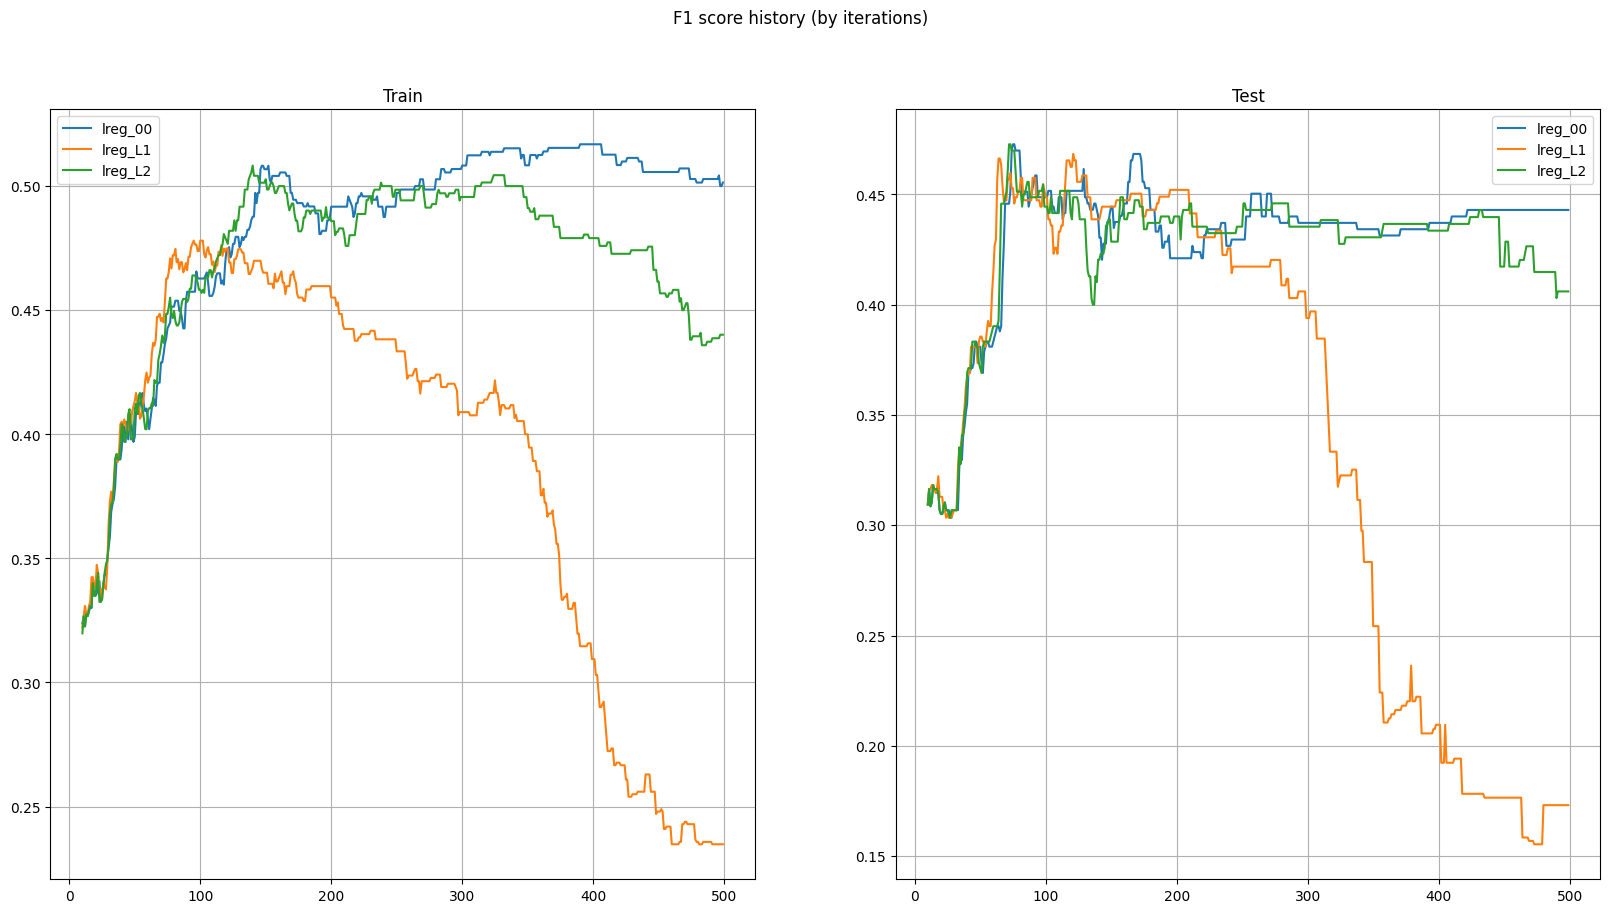

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('F1 score history (by iterations)')
fig.set_figwidth (20)
fig.set_figheight(10)


for mdl_name, mdl in models:
    ax1.plot(ITLST[10:], history['F1_train'][mdl_name][10:], label='lreg_' + mdl_name)
    ax2.plot(ITLST[10:], history['F1_test' ][mdl_name][10:], label='lreg_' + mdl_name)

ax1.legend()
ax2.legend()
ax1.set_title('Train')
ax2.set_title('Test')
ax1.grid()
ax2.grid()

plt.show()

**TODO: Analyze the results**

1. Analyze convergence (Train-graph): which model converges the fastest? with what price (what is the gain or loss)?
1. Explain why?
1. Based on that (nothing else), what is the benefit of regularization?
1. Why regularized models lose performance with much more iterations?
1. Based on that (nothing else), what is the limit of regularization?

**Answer**

1. Convergence Analysis: In the training graph, the lreg_l1 model converges the fastest, reaching an F1 score of around 0.47 after just 100 iterations, but this comes at the cost of significant long-term performance degradation, dropping to 0.22 after 500 iterations. The lreg_00 (non-regularized) and lreg_l2 (L2-regularized) models converge more slowly but steadily, with lreg_00 maintaining better performance over time, reaching about 0.51 F1 after 150 iterations, while lreg_l2 shows more stable learning but still experiences a gradual decline.
1. The rapid convergence of lreg_l1 is due to Lasso regularization, which forces many coefficients to zero, simplifying the model. However, this feature elimination leads to the loss of important information, causing underfitting over time. In contrast, lreg_00 and lreg_l2 avoid this issue by either not regularizing (lreg_00) or penalizing large weights without eliminating features (lreg_l2), allowing for more stable and sustained learning.
1. Benefit of Regularization: Regularization, particularly L1, accelerates initial convergence by simplifying the model and reducing overfitting in the early stages. It helps the model focus on the most relevant features, improving generalization, especially in noisy or high-dimensional datasets.
1. Performance Loss with More Iterations: Regularized models lose performance over time because the regularization penalty dominates the loss function, limiting the model's ability to fully adapt to the data. In lreg_l1, this results in excessive sparsity and underfitting, while in lreg_l2, the penalty on large weights prevents the model from capturing complex patterns, leading to a gradual decline in performance.
1. Limit of Regularization: The primary limit of regularization is that it can overly constrain the model’s learning capacity over time. While it helps in the early stages by preventing overfitting, excessive regularization (especially in lreg_l1) can oversimplify the model, causing it to lose its ability to capture important patterns in the data. This makes the non-regularized model (lreg_00) more effective in maintaining performance over many iterations.

#### II.1.2. Regularization and parameters

Here, we will plot parameters history.

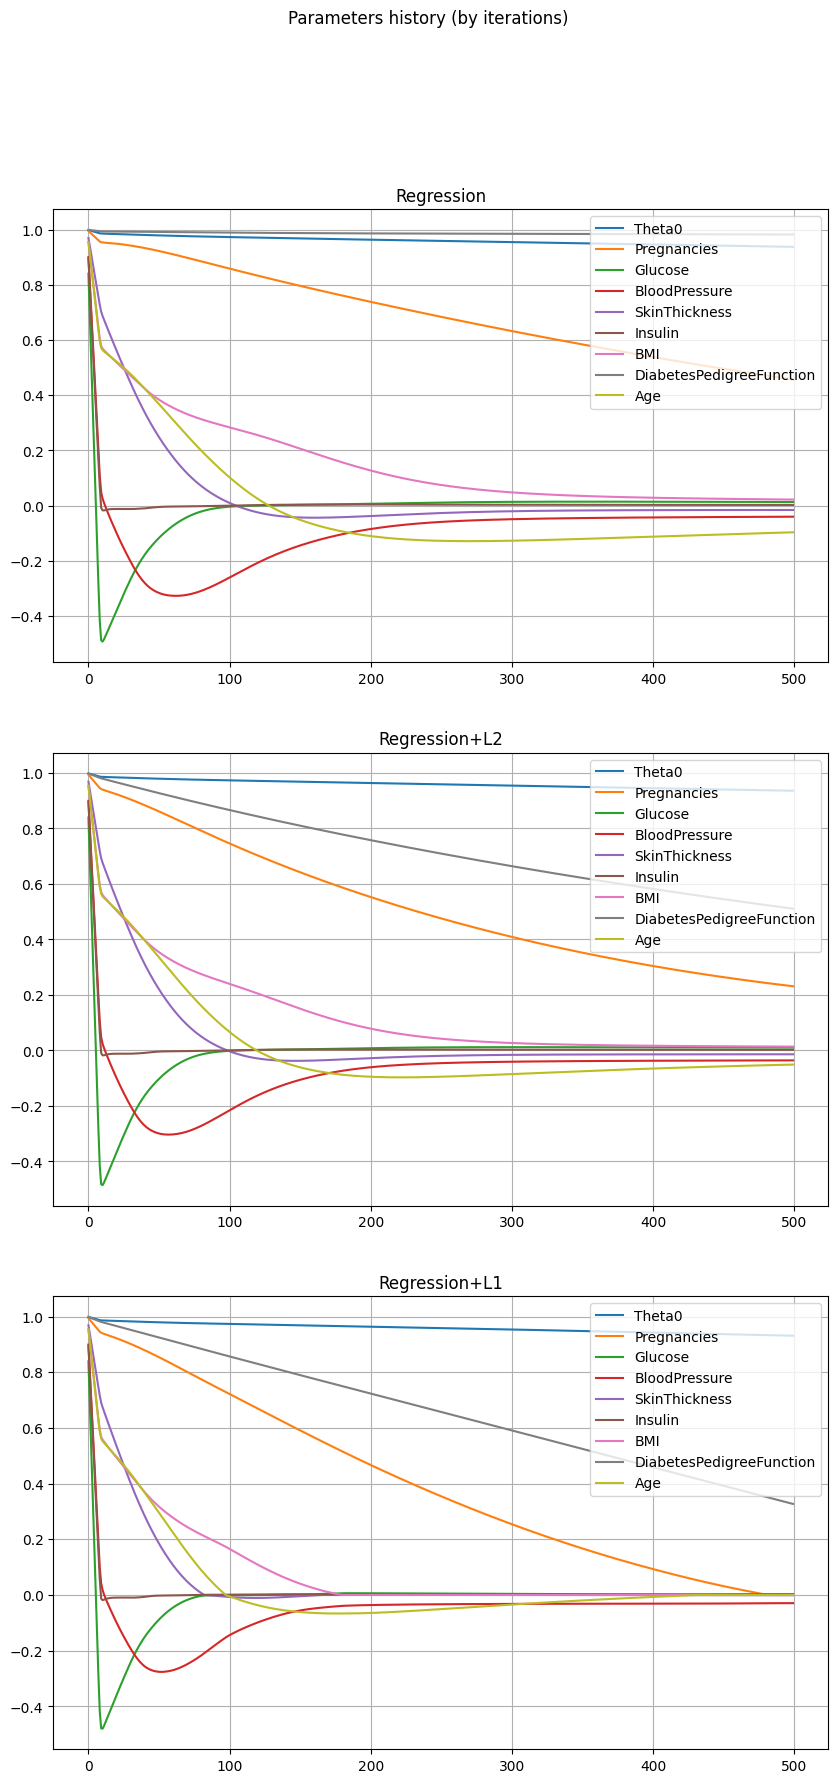

In [ ]:
labels = list(diabetes.columns)
labels.pop()
labels = ['Theta0'] + labels
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.suptitle('Parameters history (by iterations)')
fig.set_figwidth (10)
fig.set_figheight(20)
for i in range(len(labels)):
    ax1.plot(ITLST, history['Theta']['00'][:, i], label=labels[i])
    ax3.plot(ITLST, history['Theta']['L1'][:, i], label=labels[i])
    ax2.plot(ITLST, history['Theta']['L2'][:, i], label=labels[i])

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_title('Regression')
ax2.set_title('Regression+L2')
ax3.set_title('Regression+L1')

ax1.grid()
ax2.grid()
ax3.grid()

plt.show()

**TODO: Analyze the results**

1. Why when we apply regularization, parameters tend to converge more into 0?
1. Why there are parameters which coverge faster than others?
1. Can we find the most important parameters using parameters history? If so, give the two most important ones. Otherwise, explain why.
1. Can we use regularization as feature selection? If so, precise how it can be seen as such. Otherwise, precise why. Discuss L1 and L2 separately.

**Answer**

1. Why do parameters tend to converge to 0 with regularization?
Regularization adds a penalty to the cost function to control the size of the parameters. For  lreg_l2 (Ridge), the penalty is proportional to the square of the parameters (λ∑θ²), which shrinks them toward zero but rarely sets them to zero. This helps reduce the impact of less important features without eliminating them entirely. For lreg_l1 (Lasso), the penalty is proportional to the absolute value of the parameters (λ∑|θ|), which can push some parameters exactly to zero. This happens because Lasso’s penalty has no derivative at zero, allowing coefficients to become exactly zero. As a result, Lasso encourages sparsity by eliminating less important features, while Ridge shrinks parameters more gently.
1. Why do some parameters converge faster than others?
Some parameters converge faster because of their importance to the prediction. Parameters linked to more significant features (e.g., BMI or Insulin) are penalized less and converge more quickly, as they contribute more to the model’s accuracy. On the other hand, parameters associated with less important features (e.g., Guccine or BioOffensive) shrink faster, especially under lreg_l1, which can push them to zero. Additionally, features on larger scales or with higher gradients might update faster during training, leading to differences in convergence speed.
1. Can we find the most important parameters using parameters history?
Yes, we can identify the most important parameters by analyzing their values over iterations. In lreg_l1, parameters that remain non-zero are considered important because L1 zeroes out less relevant features. In lreg_l2, parameters with larger magnitudes are more influential, as L2 shrinks but does not eliminate features. For example, DiabetesPedigreeFunction and Pregnancies are likely key predictors because their parameters do not shrink as quickly compared to others.
1. Can we use regularization as feature selection?
L1 regularization can be used as a feature selection method because it adds a penalty proportional to the absolute value of the coefficients (|θ|). This penalty can drive some coefficients to exactly zero, effectively removing the corresponding features from the model. For example, if Guccine or BioOffensive are zeroed out, they can be considered irrelevant. L2 regularization, however, does not perform feature selection in the same way. It adds a penalty proportional to the squared magnitude of the coefficients (θ²), which shrinks the coefficients but rarely sets them to zero. This means L2 reduces the impact of less important features without eliminating them entirely. While L1 is effective for feature selection, L2 is better suited for reducing overfitting without removing features.

### II.2. Features selection

We will use the same dataset to test different feature selection techniques.

#### II.2.1. Filtering using ANOVA

For each feature, ANOVA F-value is calculated.


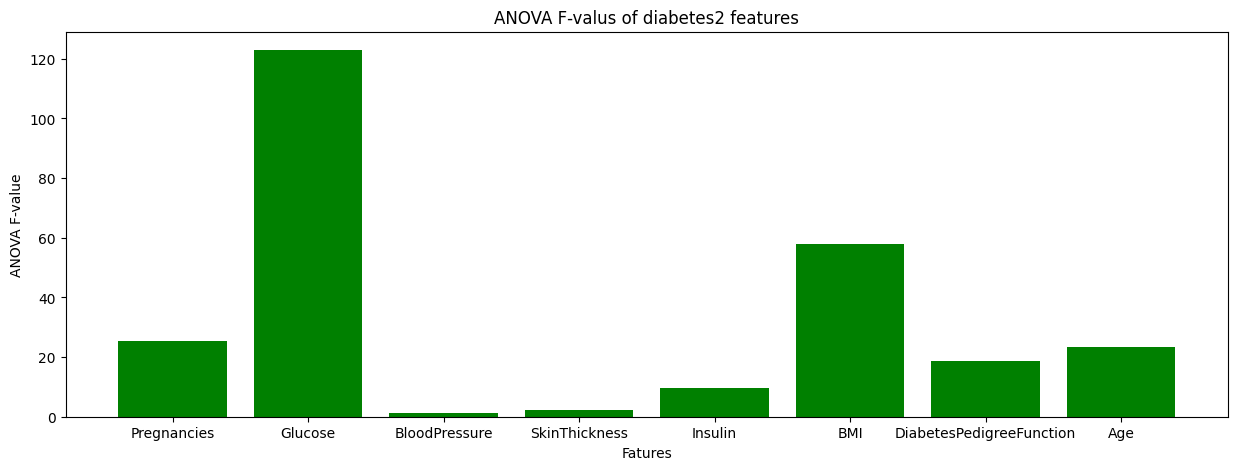

In [ ]:
f, a = f_classif(X_train, Y_train)

labels_diabetes = list(diabetes.columns[:-1])
x_pos = range(len(f))
plt.figure(figsize=(15,5))
plt.bar(labels_diabetes, f, color='green')
plt.xlabel('Fatures')
plt.ylabel('ANOVA F-value')
plt.title('ANOVA F-valus of diabetes2 features')

plt.xticks(x_pos, labels_diabetes)

plt.show()


**TODO: Analyze the results**

1. Give the two most important features according to ANOVA.
1. Why they are considered important? In this case, explain the reasoning behind ANOVA F-value.
1. Why ANOVA was used instead of Pearson?

**Answer**

1. Based on the ANOVA F-values, the two most important features are likely Glucose and BMI.
1. ANOVA (Analysis of Variance) measures the importance of features by comparing the variance between groups (e.g., diabetic vs. non-diabetic) to the variance within groups. A high F-value for a feature (e.g., Glucose or BMI) means that the differences in this feature between groups are significant compared to random variation. For example, Glucose levels are strongly linked to diabetes, and BMI is a key indicator of health risks. These features are considered important because they have a strong statistical association with the target variable.
1. ANOVA was used instead of Pearson correlation because ANOVA is better suited for comparing the means of multiple groups (e.g., diabetic vs. non-diabetic) and determining if a feature significantly impacts the target variable. Pearson correlation, on the other hand, measures linear relationships between two continuous variables. Since the target variable here is likely categorical (e.g., diabetes diagnosis), ANOVA is more appropriate for evaluating feature importance in this context.

#### II.2.2. Filtering and fitting/generalization

Here, we will use to select feeatures with 50% variance.
We want to compare two models: one trained on all features and another only on the most important ones according to ANOVA F-value.
F1-score is used to judge both fitting and generalization.


In [ ]:
selector    = SelectPercentile(score_func=f_classif, percentile=50)
X_train_new = selector.fit_transform(X_train, Y_train)
X_test_new  = selector.transform(X_test)

lreg_anova = LogisticRegression(penalty=None, solver='saga', max_iter=1, warm_start=True, random_state=0)
init_params(lreg_anova, N=X_train_new.shape[1])

history['F1_test' ]['lreg_anova'] = []
history['F1_train']['lreg_anova'] = []
history['Theta'   ]['lreg_anova'] = []

for it in ITLST:
    lreg_anova.fit(X_train_new, Y_train)
    coef = [lreg_anova.intercept_[0]]
    coef.extend(lreg_anova.coef_.flatten().tolist())
    history['Theta'   ]['lreg_anova'].append(coef)
    history['F1_test' ]['lreg_anova'].append(f1_score(Y_test, lreg_anova.predict(X_test_new)))
    history['F1_train']['lreg_anova'].append(f1_score(Y_train, lreg_anova.predict(X_train_new)))


history['Theta']['lreg_anova'] = np.array(history['Theta']['lreg_anova'])


# This is just to check the last time this was executed
# because the next cells depend on the results of this one
now = datetime.datetime.now()
print(now.strftime("%Y-%m-%d %H:%M:%S"))

2024-12-07 19:45:21


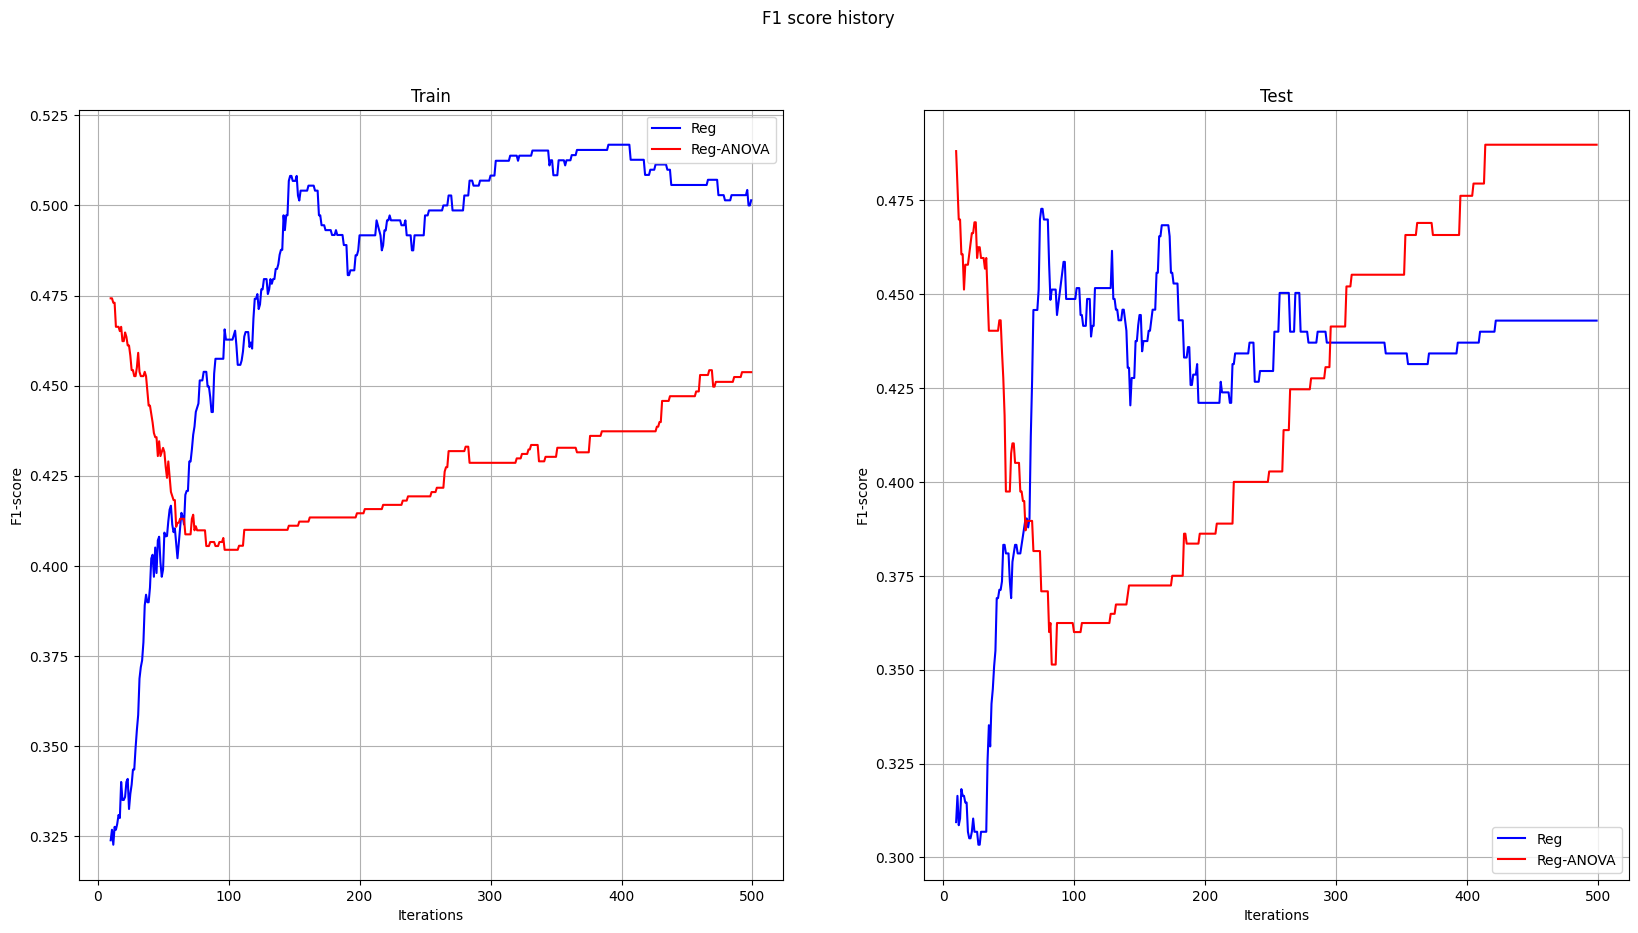

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('F1 score history')
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(ITLST[10:], history['F1_train' ]['00'        ][10:], color='blue', label='Reg'      )
ax1.plot(ITLST[10:], history['F1_train' ]['lreg_anova'][10:], color='red' , label='Reg-ANOVA')
ax2.plot(ITLST[10:], history['F1_test'  ]['00'        ][10:], color='blue', label='Reg'      )
ax2.plot(ITLST[10:], history['F1_test'  ]['lreg_anova'][10:], color='red' , label='Reg-ANOVA')

ax1.set_xlabel('Iterations')
ax1.set_ylabel('F1-score')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('F1-score')

ax1.legend()
ax2.legend()
ax1.set_title('Train')
ax2.set_title('Test')
ax1.grid()
ax2.grid()

plt.show()

**TODO: Analyze the results**

1. Based on train graph, logistic regression without filtering fits quickly and perfectly. Why filtering features decreases fitting capacity either speeed or prformance?
1. Based on test graph, logistic regression without filtering generalizes quickly with less performance. On the other hand, filtering features generalizes slowly with an increasing performance. Why?
1. **Can** filtering prevent overfitting with more iterations? If so, how? If not, why?
1. **Can** filtering prevent underfitting with less iterations? If so, how? If not, why?

**Answer**

1. Logistic regression without filtering fits quickly and perfectly because it uses all available features, allowing it to learn both relevant and irrelevant patterns. Filtering features reduces the number of attributes, focusing only on the most relevant ones. While this helps avoid overfitting, it decreases the model's fitting capacity during training, slowing convergence and potentially lowering performance because the model has fewer inputs to optimize.
1. On the test graph, logistic regression without filtering generalizes quickly but with lower performance because it overfits the training data by capturing noise from irrelevant features. Filtering features removes these irrelevant attributes, making the model initially slower to generalize. However, over time, the model focuses on meaningful patterns, leading to a steady increase in test performance and better generalization.
1. Yes, filtering can help prevent overfitting with more iterations. By selecting only the most relevant features, filtering reduces noise and complexity, preventing the model from fitting irrelevant patterns specific to the training data. This allows the model to focus on meaningful relationships, improving generalization and reducing overfitting.
1. No, filtering alone cannot prevent underfitting with fewer iterations. Underfitting occurs when the model is too simple or not trained enough to capture data patterns. While filtering helps focus on relevant features, too few iterations may prevent the model from learning effectively. To avoid underfitting, both the number of features and iterations must be balanced to ensure the model learns properly.

#### II.2.3. Feature selection comparison

We want to compare different feature selection methods:
- **ANOVA**: Filter based feature selection. We selected 4 features.
- **L1**: Embdded feature selection.
- **FFS (Forward Features Selection)**: Wrapper feature selection. It starts by testing one feature, then adding others till reaching the desired features' number. We selected 4 features.
- **BFE (Backward Features Elimination)**: Wrapper feature selection. It starts by testing all features, then deleting one by one till reaching the desired features' number. We selected 4 features.

The generated models using these 4 methods are evaluated using the following criteria:
- **F1 train**: to answer the question '*how much a model can converge to its global solution?*'
- **F1 test**: to answer the question '*how much a model can generalize on unseen data?*'
- **Iterations number**: to answer the question '*how much iterations are enough to converge?*'
- **Pre-train time**: to answer the question '*how much time data takes to be prepared for processing?*'
- **Train time**: to answer the question '*how much time a model takes to be trained?*'

*P.S. Execution takes time; be patient till you die of boredom*


In [ ]:
CMAX_ITER = 5000
clreg_000  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)
clreg_l1l  = LogisticRegression(penalty='l1', solver='saga', max_iter=CMAX_ITER)
clreg_anv  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)
clreg_ffs  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)
clreg_bfe  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)

time_pp = {}
time_tr = {}

# Normal Logistic Rgression
# ==============================
start_time = timeit.default_timer()
clreg_000.fit(X_train, Y_train)
time_tr['reg'] = timeit.default_timer() - start_time
# ===============================


# L1 Logistic Rgression
# ===============================
start_time = timeit.default_timer()
clreg_l1l.fit(X_train, Y_train)
time_tr['l1'] = timeit.default_timer() - start_time
# ===============================

# Normal Logistic Rgression
# using ANOVA selected features
# ===============================
# Features selection before training
selector_anova = SelectPercentile(score_func=f_classif, percentile=50)
start_time = timeit.default_timer()
X_train_anova = selector_anova.fit_transform(X_train, Y_train)
time_pp['anova'] = timeit.default_timer() - start_time
X_test_anova = selector_anova.transform(X_test)
# Training on selected features
start_time = timeit.default_timer()
clreg_anv.fit(X_train_anova, Y_train)
time_tr['anova'] = timeit.default_timer() - start_time
# ===============================

# Logistic Rgression
# using FFS selected features
# ===============================
# Features selection before training
start_time = timeit.default_timer()
selecteur_ffs = SequentialFeatureSelector(clreg_ffs, n_features_to_select=4, direction='forward')
X_train_ffs = selecteur_ffs.fit_transform(X_train, Y_train)
time_pp['ffs'] = timeit.default_timer() - start_time
X_test_ffs = selecteur_ffs.transform(X_test)
# Training on selected features
start_time = timeit.default_timer()
clreg_ffs.fit(X_train_ffs, Y_train)
time_tr['ffs'] = timeit.default_timer() - start_time
# ===============================

# Logistic Rgression
# using BFE selected features
# ===============================
# Features selection before training
start_time = timeit.default_timer()
selecteur_bfe = SequentialFeatureSelector(clreg_bfe, n_features_to_select=4, direction='backward')
X_train_bfe = selecteur_bfe.fit_transform(X_train, Y_train)
time_pp['bfe'] = timeit.default_timer() - start_time
X_test_bfe = selecteur_bfe.transform(X_test)
# Training on selected features
start_time = timeit.default_timer()
clreg_bfe.fit(X_train_bfe, Y_train)
time_tr['bfe'] = timeit.default_timer() - start_time
# ===============================

pd.DataFrame({
    'Criteria' : ['F1 Train',
                  'F1 Test',
                  'Iterations',
                  'Pre-train time',
                  'Train time'],
    'Reg'      : [f1_score(Y_train, clreg_000.predict(X_train)),
                  f1_score(Y_test, clreg_000.predict(X_test)),
                  clreg_000.n_iter_,
                  0,
                  time_tr['reg']],
    'Reg+L1'   : [f1_score(Y_train, clreg_l1l.predict(X_train)),
                  f1_score(Y_test, clreg_l1l.predict(X_test)),
                  clreg_l1l.n_iter_,
                  0,
                  time_tr['l1']],
    'ANOVA+Reg': [f1_score(Y_train, clreg_anv.predict(X_train_anova)),
                  f1_score(Y_test, clreg_anv.predict(X_test_anova)),
                  clreg_anv.n_iter_,
                  time_pp['anova'],
                  time_tr['anova']],
    'FFS'      : [f1_score(Y_train, clreg_ffs.predict(X_train_ffs)),
                  f1_score(Y_test, clreg_ffs.predict(X_test_ffs)),
                  clreg_ffs.n_iter_,
                  time_pp['ffs'],
                  time_tr['ffs']],
    'BFE'      : [f1_score(Y_train, clreg_bfe.predict(X_train_bfe)),
                  f1_score(Y_test, clreg_bfe.predict(X_test_bfe)),
                  clreg_bfe.n_iter_,
                  time_pp['bfe'],
                  time_tr['bfe']],
})

,Criteria,Reg,Reg+L1,ANOVA+Reg,FFS,BFE
0,F1 Train,0.465574,0.465574,0.388278,0.567568,0.585526
1,F1 Test,0.380165,0.380165,0.37931,0.564516,0.539683
2,Iterations,[1407],[1405],[268],[5000],[5000]
3,Pre-train time,0,0,0.000708,5.7418,12.631942
4,Train time,0.056523,0.060502,0.007806,0.13123,0.129812


**TODO: Analyze the results**

1. Why L1-based model takes more time to train than the one using normal one although it takes less iterations?
1. Why L1-based model takes less iterations to converge than normal one?
1. We've seen in the past experiment that ANOVA can generalize better. But, in here it is not as good as normal regression. Why?
1. Why wrapper-based models take more time to train than the normal one although they use less features?
1. Why wrapper-based models give better performance (fitting and generalization) than filter based (ANOVA) one?
1. What can we conclude when we see that wrapper-based models reach the maximum iterations?
1. When FFS pretrain time is better than that of BFE and the inverse?

**Answer**

1. The L1-based model (RegH1) takes more time per iteration because L1 regularization involves penalizing the absolute values of coefficients, which adds extra computational complexity. During training, the algorithm must perform additional calculations to enforce sparsity and solve the optimization problem more carefully. This means that while each iteration might be more computationally intensive, it actually helps reduce the number of parameters more efficiently.
1. The L1-based model converges in fewer iterations because L1 regularization encourages sparsity by effectively reducing the number of non-zero coefficients. This means fewer coefficients need to be optimized, which narrows the search space for model parameters. Consequently, the model can converge faster because it has fewer parameters to fine-tune, leading to quicker convergence.
1. In this case, ANOVA+Reg performs worse because ANOVA (filter-based feature selection) only considers the linear correlation between individual features and the target variable. It doesn't account for complex interactions between features. In this specific experiment, the linear correlation might not capture the full complexity of the data, leading to reduced generalization compared to normal regression.
1. Wrapper-based models (FFS and BFE) take more time to train because they involve an iterative process of evaluating different feature subsets. This requires repeatedly training and testing the model, which increases computational overhead despite using fewer features in the final model. Wrapper methods like Forward Feature Selection (FFS) and Backward Feature Elimination (BFE) perform an exhaustive, iterative search over feature subsets, requiring significantly more computational resources compared to normal regression.
1. Wrapper-based models perform better because they evaluate how subsets of features work together to improve model performance, unlike filter methods that only look at individual feature correlations. By considering feature interactions, wrapper methods can select a more robust set of features that better captures the underlying data patterns, leading to improved fitting and generalization.
1. If wrapper-based models reach the maximum iterations, it suggests that the feature selection process is highly  computational or that the optimal feature subset is difficult to find within the given iteration limit. Reaching maximum iterations indicates that the models require extensive computational effort to explore all possible feature combinations. While this suggests superior feature selection, it also highlights the significant computational burden of wrapper methods. They provide better performance at the cost of increased training time and computational complexity.
1. FFS (Forward Feature Selection) pretrain time is better than BFE (Backward Feature Elimination) when the number of relevant features is small. FFS starts with no features and adds them progressively, so it can stop early if performance stabilizes, making it efficient for datasets with a limited and clear set of potentially important features. BFE pretrain time becomes favorable when the dataset has many irrelevant or redundant features. Starting with all features, BFE efficiently improves model performance by removing irrelevant ones, particularly in high-dimensional datasets with redundant attributes.

In [ ]:
print('This lab is finished, and all ML\'s suffering with it')

This lab is finished, and all ML's suffering with it
